In [29]:
#https://www.kaggle.com/datasets/saicharansirangi/adanalyse
import jax.numpy as jnp
import numpyro
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

# Preparing the Data

In [12]:
# Load the dataset from an Excel file
data = pd.read_excel("Sr Advertising Analyst Work Sample (1).xlsx")

# Group data by 'Date' and 'Ad group alias', and sum the values for 'Impressions', 'Spend', and 'Sales'
agg_data = data.groupby(["Date", "Ad group alias"])[["Impressions", "Spend", "Sales"]].sum()

# Drop the 'Brand 1 Ad Group 12' from the data as it has zero cost in the training dataset
agg_data = agg_data.drop(["Brand 1 Ad Group 12"], axis=0, level=1)

# Unstack 'Impressions' column: This reshapes the data from a multi-index series to a dataframe
# where each column represents an 'Ad group alias' and each row represents a 'Date'. Fill NaN values with 0.
media_data_raw = agg_data['Impressions'].unstack().fillna(0)

# Similarly, unstack 'Spend' and 'Sales' columns to align them with 'Impressions'
costs_raw = agg_data['Spend'].unstack()
sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()
data

,Date,Brand Alias,Ad group alias,ASIN/SKU Alias,Marketplace,Impressions,Clicks,Spend,Sales,Orders,Units,Advertised Units sold,Other SKU units sold,Advertised SKU Sales,Other SKU sales
0,2021-10-17,Brand 1,Brand 1 Ad Group 10,ASIN414,Walmart,33,0,0.000,0.0000,0,0,0,0,0.00,0.00
1,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN385,Walmart,0,0,0.000,0.0000,0,0,0,0,0.00,0.00
2,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN389,Walmart,0,0,0.000,0.0000,0,0,0,0,0.00,0.00
3,2021-10-17,Brand 1,Brand 1 Ad Group 13,ASIN377,Walmart,380,8,2.340,0.0000,0,0,0,0,0.00,0.00
4,2021-10-17,Brand 1,Brand 1 Ad Group 13,ASIN399,Walmart,3805,7,6.684,0.0000,0,0,0,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9581,2022-01-11,Brand 2,Brand 2 Ad Group 2,ASIN508,Amazon,4639,10,7.360,0.0000,0,0,0,0,0.00,0.00
9582,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN512,Amazon,15336,49,33.790,638.7375,6,6,1,5,55.99,455.00
9583,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN516,Amazon,4811,6,3.660,0.0000,0,0,0,0,0.00,0.00
9584,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN520,Amazon,22838,36,19.570,294.9500,4,4,3,1,158.97,76.99


In [8]:
data.dtypes

Date                     datetime64[ns]
Brand Alias                      object
Ad group alias                   object
ASIN/SKU Alias                   object
Marketplace                      object
Impressions                       int64
Clicks                            int64
Spend                           float64
Sales                           float64
Orders                            int64
Units                             int64
Advertised Units sold             int64
Other SKU units sold              int64
Advertised SKU Sales            float64
Other SKU sales                 float64
dtype: object

In [9]:
data.columns

Index(['Date', 'Brand Alias', 'Ad group alias', 'ASIN/SKU Alias',
       'Marketplace', 'Impressions', 'Clicks', 'Spend', 'Sales', 'Orders',
       'Units', 'Advertised Units sold', 'Other SKU units sold',
       'Advertised SKU Sales', 'Other SKU sales'],
      dtype='object')

In [19]:
# Define the split point
split_point = pd.Timestamp("2021-12-15")

# Ensure the split point is within the dataset range
if split_point in media_data_raw.index:
    # Splitting media data into training and testing sets
    media_data_train = media_data_raw.loc[:split_point - pd.Timedelta(1, 'D')]
    media_data_test = media_data_raw.loc[split_point:]

    # Splitting target (sales) data into training and testing sets
    target_train = sales_raw.loc[:split_point - pd.Timedelta(1, 'D')]
    target_test = sales_raw.loc[split_point:]

    # Calculating costs for training period
    costs_train = costs_raw.loc[:split_point - pd.Timedelta(1, 'D')].sum(axis=0).loc[media_data_train.columns]

    # Generating organic data
    np.random.seed(0)  # For reproducibility
    organic_raw = pd.DataFrame({'organic_search': 0, 'organic_social': 0}, index=media_data_raw.index)
    organic_sales_values = sales_raw['Sales'].astype(float).values  # Ensure values are floats
    organic_raw['organic_search'] = organic_sales_values / 10 + np.random.randint(10000, 100000, size=organic_raw.shape[0])
    organic_raw['organic_social'] = organic_sales_values / 10 + np.random.randint(10000, 100000, size=organic_raw.shape[0])
else:
    print("Split point is not within the dataset range. Please check your dates.")

In [21]:
# organic_search: Simulates organic traffic from search engines. This represents the engagement or visits a website receives from unpaid search results, typically influenced by search engine optimization (SEO) efforts. It's calculated as a fraction of sales data plus a random component to introduce variability.

# organic_social: Simulates organic engagement from social media platforms. This column represents the traffic or engagement received through non-paid means, like natural shares, likes, or posts on a company's social media profiles. Similar to organic search, it's derived from a fraction of sales data with an added random component for variability.

organic_raw

,organic_search,organic_social
Date,,
2021-10-17,81087.50575,102002.50575
2021-10-18,56116.07750,52682.07750
2021-10-19,56018.49375,68558.49375
2021-10-20,58911.44050,75776.44050
2021-10-21,34689.12050,95203.12050
...,...,...
2022-01-07,92785.00400,41170.00400
2022-01-08,22075.41950,95450.41950
2022-01-09,93551.48625,28625.48625


# Scaling The Data

In [27]:
# Split organic data into training and testing sets based on the split point
organic_data_train = organic_raw.loc[:split_point - pd.Timedelta(1, 'D')]
organic_data_test = organic_raw.loc[split_point:]

# Initialize scalers for media, organic, target (sales), and costs data
# Using CustomScaler with mean as the divide operation for normalization
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

# Scale training data using the respective scalers
media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
organic_data_train_scaled = organic_scaler.fit_transform(organic_data_train.values)
target_train_scaled = target_scaler.fit_transform(target_train['Sales'].astype(float).values.squeeze())
costs_scaled = cost_scaler.fit_transform(costs_train.values)

# Scale testing data (only transform, as the model should not learn from testing data)
media_data_test_scaled = media_scaler.transform(media_data_test.values)
organic_data_test_scaled = organic_scaler.transform(organic_data_test.values)

# Store the names of media channels for future reference
media_names = media_data_raw.columns

# Hyperparameter Tuning

In [36]:
adstock_models = ["adstock", "hill_adstock", "carryover"]
degrees_season = [1,2,3]

# Iterate over each model and degree of seasonality
for model_name in adstock_models:
    for degrees in degrees_season:
        # Initialize the LightweightMMM model with specified parameters
        mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
        # Fit the model to the training data
        mmm.fit(
            media=media_data_train_scaled,
            media_prior=costs_scaled,
            target=target_train_scaled,
            extra_features=organic_data_train_scaled,
            number_warmup=1000,
            number_samples=1000,
            number_chains=1,
            degrees_seasonality=degrees,
            weekday_seasonality=True,
            seasonality_frequency=365,
            seed=1
        )

        # Predict using the model on test data
        prediction = mmm.predict(
            media=media_data_test_scaled,
            extra_features=organic_data_test_scaled,
            target_scaler=target_scaler
        )
        p = prediction.mean(axis=0)

        # Calculate the Mean Absolute Percentage Error (MAPE)
        mape = mean_absolute_percentage_error(target_test['Sales'].astype(float).values, p)
        print(f"model_name={model_name} degrees={degrees} MAPE={mape} samples={p[:3]}")

sample: 100%|██████████| 2000/2000 [00:35<00:00, 56.81it/s, 1023 steps of size 5.48e-03. acc. prob=0.80]


model_name=adstock degrees=1 MAPE=0.13815459576825026 samples=[30050.174 30058.537 29521.695]


sample: 100%|██████████| 2000/2000 [00:41<00:00, 48.48it/s, 1023 steps of size 3.57e-03. acc. prob=0.94]


model_name=adstock degrees=2 MAPE=0.3041605588534186 samples=[29475.06  29211.238 28458.979]


sample: 100%|██████████| 2000/2000 [00:35<00:00, 55.84it/s, 1023 steps of size 5.68e-03. acc. prob=0.80]


model_name=adstock degrees=3 MAPE=0.5756250713617705 samples=[28193.895 27556.273 26228.738]


sample: 100%|██████████| 2000/2000 [00:20<00:00, 95.97it/s, 511 steps of size 6.15e-03. acc. prob=0.92]  


model_name=hill_adstock degrees=1 MAPE=0.1714074262903557 samples=[33889.223 33299.668 33069.496]


sample: 100%|██████████| 2000/2000 [00:21<00:00, 92.95it/s, 511 steps of size 7.99e-03. acc. prob=0.81] 


model_name=hill_adstock degrees=2 MAPE=0.21885346262753802 samples=[32644.643 31559.6   30911.268]


sample: 100%|██████████| 2000/2000 [00:28<00:00, 70.92it/s, 1023 steps of size 5.33e-03. acc. prob=0.90]


model_name=hill_adstock degrees=3 MAPE=0.22601855742125002 samples=[32345.582 31027.676 30473.596]


sample: 100%|██████████| 2000/2000 [02:02<00:00, 16.26it/s, 255 steps of size 1.47e-02. acc. prob=0.88]


model_name=carryover degrees=1 MAPE=0.10048341215157608 samples=[30295.256 29732.867 29468.33 ]


sample: 100%|██████████| 2000/2000 [03:16<00:00, 10.15it/s, 511 steps of size 8.79e-03. acc. prob=0.93]


model_name=carryover degrees=2 MAPE=0.5290717765193821 samples=[28074.37  25816.383 25213.97 ]


sample: 100%|██████████| 2000/2000 [04:54<00:00,  6.78it/s, 1023 steps of size 3.80e-03. acc. prob=0.96]


model_name=carryover degrees=3 MAPE=0.788402733396885 samples=[27149.316 24041.635 22745.572]


# Fitting the Model

In [46]:
costs = costs_raw.sum(axis=0).loc[media_names]

media_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler2 = preprocessing.CustomScaler(
    divide_operation=jnp.mean)
cost_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_scaled = media_scaler2.fit_transform(media_data_raw.values)
organic_data_scaled = organic_scaler2.fit_transform(organic_raw.values)
target_scaled = target_scaler2.fit_transform(sales_raw['Sales'].astype(float).values)
costs_scaled2 = cost_scaler2.fit_transform(costs.values)

media_names = media_data_raw.columns

mmm = lightweight_mmm.LightweightMMM(model_name="carryover")
mmm.fit(media=media_data_scaled,
        media_prior=costs_scaled2,
        extra_features=organic_data_scaled,
        target=target_scaled,
        number_warmup=1000,
        number_samples=1000,
        number_chains=1,
        degrees_seasonality=1,
        weekday_seasonality=True,
        seasonality_frequency=365,
        seed=1)

sample: 100%|██████████| 2000/2000 [01:48<00:00, 18.51it/s, 255 steps of size 1.21e-02. acc. prob=0.65] 


# Plotting

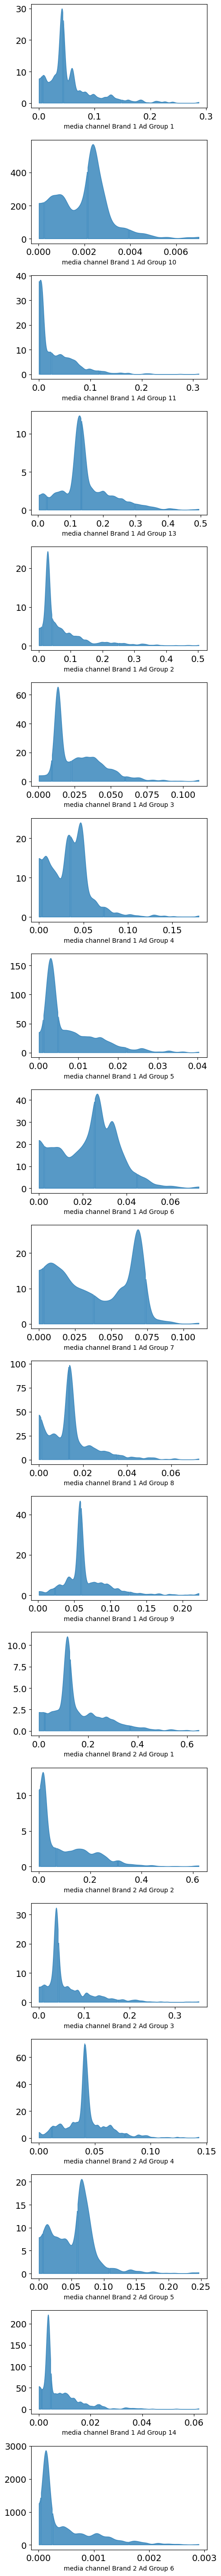

In [48]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)

In [56]:
media_contribution_pct, roi_hat = mmm.get_posterior_metrics(
    cost_scaler=cost_scaler2, 
    target_scaler=target_scaler2
)

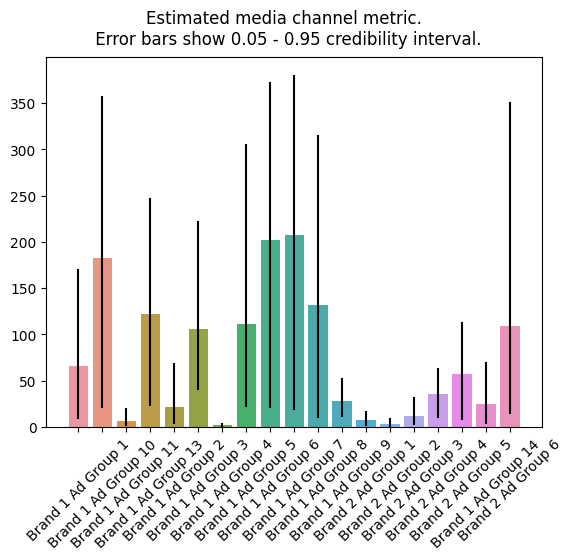

In [60]:
plot.plot_bars_media_metrics(metric=roi_hat, channel_names=media_names)

# Optimize Media

In [95]:
prices = jnp.ones(mmm.n_media_channels)

# Convert Pandas Series to a numpy array
average_spend_per_channel = np.array(media_data_raw.mean(axis=0))

# Ensure prices is a numpy array as well
prices = np.array(prices)

# Calculate budget using numpy operations and then cast to jnp array if needed
budget = jnp.array(np.sum(prices * average_spend_per_channel) * 10)

# Run optimization with the specified parameters.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=10,  # Define the number of time periods you want to optimize for
    media_mix_model=mmm,  # Your trained LightweightMMM model
    extra_features=organic_data_scaled[-10:, :],  # Use the last 10 rows of your scaled organic data
    budget=budget,  # The total budget you have set for the media
    prices=prices,  # The prices array as calculated earlier
    media_scaler=media_scaler,  # The scaler used for media data
    target_scaler=target_scaler,  # The scaler used for target variable
    seed=1  # Set a seed for reproducibility
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -334833.5567096917
            Iterations: 146
            Function evaluations: 5655
            Gradient evaluations: 145


In [96]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

array([4.43621719e+04, 3.19525421e+02, 8.65542375e+05, 2.35178875e+05,
       3.07092406e+05, 3.79362744e+03, 3.59021500e+06, 4.65559357e+02,
       5.36847461e+03, 7.44366162e+03, 6.32196729e+03, 1.07695938e+05,
       4.19150600e+06, 4.76517741e+06, 1.28371575e+06, 3.09438312e+05,
       2.30177906e+05, 1.10530984e+05, 1.80508521e+03])

In [98]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([3.5958742e+04, 2.5899844e+02, 7.0158462e+05, 1.9062947e+05,
       2.4892059e+05, 3.0750090e+03, 4.3651935e+06, 3.7736951e+02,
       4.3515371e+03, 6.0336260e+03, 5.1244111e+03, 8.7295336e+04,
       3.3975185e+06, 5.4508305e+06, 1.0405443e+06, 2.5082211e+05,
       1.8657583e+05, 8.9593352e+04, 1.4631520e+03], dtype=float32)

In [99]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(16066151.03448276, dtype=float64), 16066151.034482755)

In [100]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(16066151.03448276, dtype=float64), Array(16066150., dtype=float32))

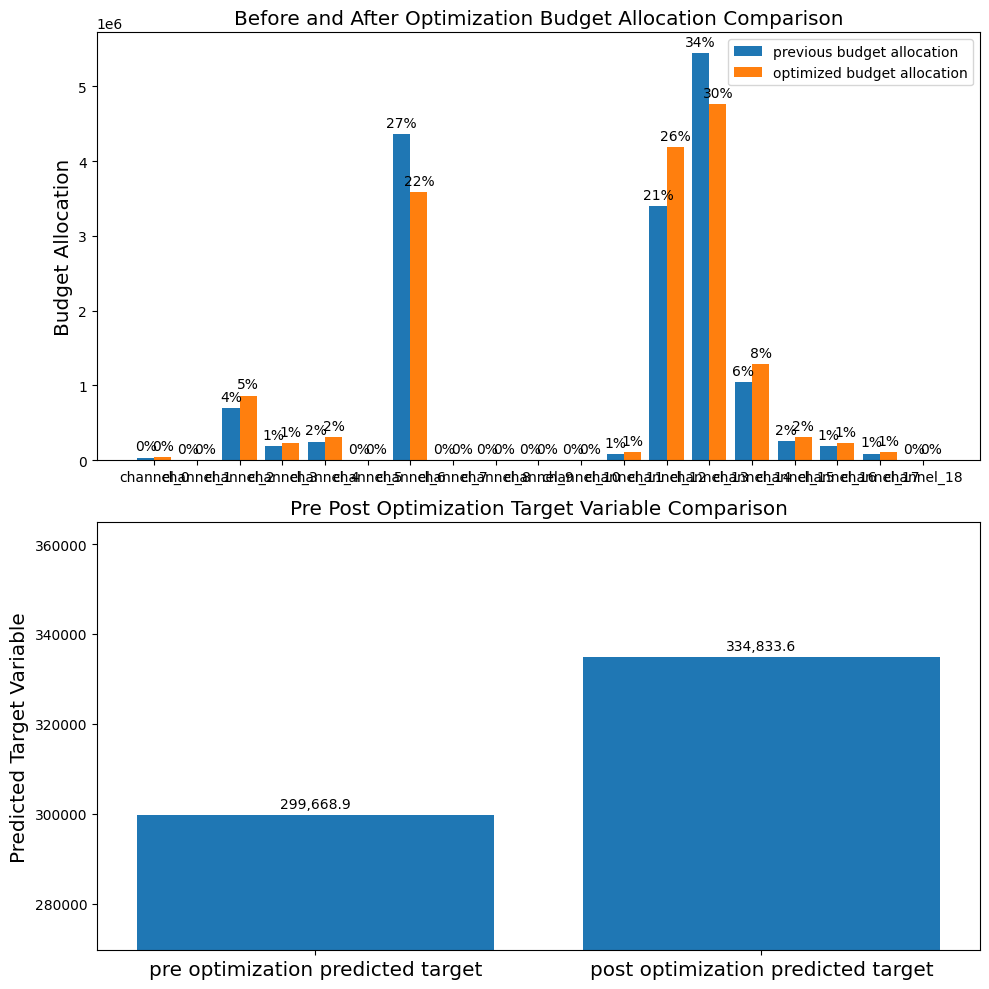

In [101]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10))